<a href="https://colab.research.google.com/github/leeh-nix/manga-colourization/blob/master/imgToImgTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
# !pip install IPython
import os
import pathlib
import time
import datetime

# from keras import tf.keras.layers
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


### Path to Dataset

In [ ]:
# dataset_path = pathlib.Path(
#     "./dataset"
# )
dataset_path = pathlib.Path(
    "/content/drive/MyDrive/dataset"
)

for folder in dataset_path.iterdir():
    print(folder)

# Path to colored and grayscaled image folders
colored_path = dataset_path / "colored"
grayscaled_path = dataset_path / "grayscaled"
dataset_test = dataset_path / "test"

/content/drive/MyDrive/dataset/test
/content/drive/MyDrive/dataset/colored full
/content/drive/MyDrive/dataset/grayscaled full
/content/drive/MyDrive/dataset/grayscaled
/content/drive/MyDrive/dataset/colored


### Fetch a sample image from the colored folder

In [ ]:
# sample_colored_image = list(colored_path.glob("*"))[0]
# print(sample_colored_image)
# image = tf.io.read_file(str(sample_colored_image))
# image = tf.image.decode_image(image)
# # plt.figure()
# # plt.imshow(image)
# # plt.title("Sample Colored Image")
# # plt.show()

### Fetch a sample image from the grayscaled folder

In [ ]:
# sample_grayscaled_image = list(grayscaled_path.glob("*"))[0]  # Fetch the first image
# print(sample_grayscaled_image)
# image = tf.io.read_file(str(sample_grayscaled_image))
# image = tf.image.decode_image(image)
# print(type(image))
# plt.figure()
# plt.imshow(image, cmap="gray")
# plt.title("Sample Grayscaled Image")
# plt.show()

### Loading the files and normalizing

In [ ]:
def load(input_image_file, real_image_file):
    input_image = tf.io.read_file(input_image_file)
    input_image = tf.image.decode_jpeg(input_image, channels=1)
    input_image = tf.cast(input_image, tf.float32)
    input_image = input_image / 255.0

    real_image = tf.io.read_file(real_image_file)
    real_image = tf.image.decode_jpeg(real_image, channels=3)
    real_image = tf.cast(real_image, tf.float32)
    real_image = real_image / 255.0
    # print("input: ", input_image_file, " real: ", real_image_file)

    return input_image, real_image



# Testing Load input and real images

# input_image, real_image = load(
#     f"{grayscaled_path}/1_31.jpg", f"{colored_path}/1_31.jpg"

# )


# print(type(input_image))
# print(type(real_image))

### Cast images for visualization

In [ ]:
# # Assuming input_image and real_image are TensorFlow eager tensors
# # Convert them to NumPy arrays
# # input_image_np = input_image.numpy()
# # real_image_np = real_image.numpy()

# # Plot the images
# plt.figure()
# # plt.imshow(input_image_np[:, :, 0], cmap="gray")
# plt.imshow(input_image, cmap="gray")
# plt.title("Input Image")
# plt.show()

# plt.figure()
# # plt.imshow(real_image_np[:, :, :])
# plt.imshow(real_image)
# plt.title("Real Image")
# plt.show()

### Skipping the "As described in the [pix2pix](https://arxiv.org/abs/1611.07004) paper, you need to apply random jittering and mirroring to preprocess the training set." part of preprocessing

### Fetch the file paths for grayscale and colored images


In [ ]:
grayscale_images = tf.data.Dataset.list_files(f"{grayscaled_path}/*.jpg", shuffle=False)
colored_images = tf.data.Dataset.list_files(f"{colored_path}/*.jpg", shuffle=False)

paired_images = tf.data.Dataset.zip((grayscale_images, colored_images))
paired_images = paired_images.map(load)

# BATCH_SIZE = 32
BATCH_SIZE = 16
# Adjust buffer size as needed for shuffling (at least > than your len(dataset))
BUFFER_SIZE = 550
paired_images = paired_images.shuffle(BUFFER_SIZE)
paired_images = paired_images.batch(BATCH_SIZE)

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


# down_model = downsample(3, 4)
# down_result = down_model(tf.expand_dims(input_image, 0))
# print(down_result.shape)

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print(up_result.shape)

### Build the Generator

In [ ]:
def build_generator():
    inputs = tf.keras.layers.Input(
        shape=(256, 256, 1)
    )  # Input shape for grayscale images

    down_stack = [
        downsample(64, 4, apply_batchnorm=True),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        3,  # Output has 3 channels (RGB)
        4,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        activation="tanh",
    )

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


# Create the generator
# generator = build_generator()
# gen_output = generator(input_image[tf.newaxis, ..., tf.newaxis], training=False)

# Assuming gen_output is in the range [-1, 1]
# gen_output = (gen_output + 1) / 2.0

# plt.imshow(gen_output[0, ...])
# plt.show()

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

[The Training Procedure for the generator(image)](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/generative/images/gen.png)

### Build the discriminator

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.0, 0.02)

    inp = tf.keras.layers.Input(
        shape=[256, 256, 1], name="input_image"
    )  # Grayscale image
    tar = tf.keras.layers.Input(
        shape=[256, 256, 3], name="target_image"
    )  # Colored image

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer, use_bias=False
    )(
        zero_pad1
    )  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(
        zero_pad2
    )  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    # Adversarial loss for real images
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(
        tf.zeros_like(disc_generated_output), disc_generated_output
    )
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

### Test the Discriminator

In [ ]:
# discriminator = Discriminator()
# disc_out = discriminator([input_image, gen_output], training=False)
# plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap="RdBu_r")
# plt.colorbar()

In [ ]:
# Initialize the generator and discriminator models
generator = build_generator()
discriminator = Discriminator()
# Sample input and target
input_image, real_image = load(
    f"{grayscaled_path}/1_59.jpg", f"{colored_path}/1_59.jpg"
    # f"{grayscaled_path}/1_31.jpg", f"{colored_path}/1_31.jpg"
)
input_image = tf.expand_dims(input_image, axis=0)
real_image = tf.expand_dims(real_image, axis=0)

# Generate output with the generator
gen_output = generator(input_image, training=True)

# Get discriminator outputs
disc_real_output = discriminator([input_image, real_image], training=True)
disc_generated_output = discriminator([input_image, gen_output], training=True)

# Calculate losses
gen_loss, gan_loss, l1_loss = generator_loss(
    disc_generated_output, gen_output, real_image
)
disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

print(
    f"Generator Loss: {gen_loss.numpy()}, GAN Loss: {gan_loss.numpy()}, L1 Loss: {l1_loss.numpy()}"
)
print(f"Discriminator Loss: {disc_loss.numpy()}")

Generator Loss: 87.0942153930664, GAN Loss: 1.0221229791641235, L1 Loss: 0.8607209324836731
Discriminator Loss: 1.6991660594940186


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.show()

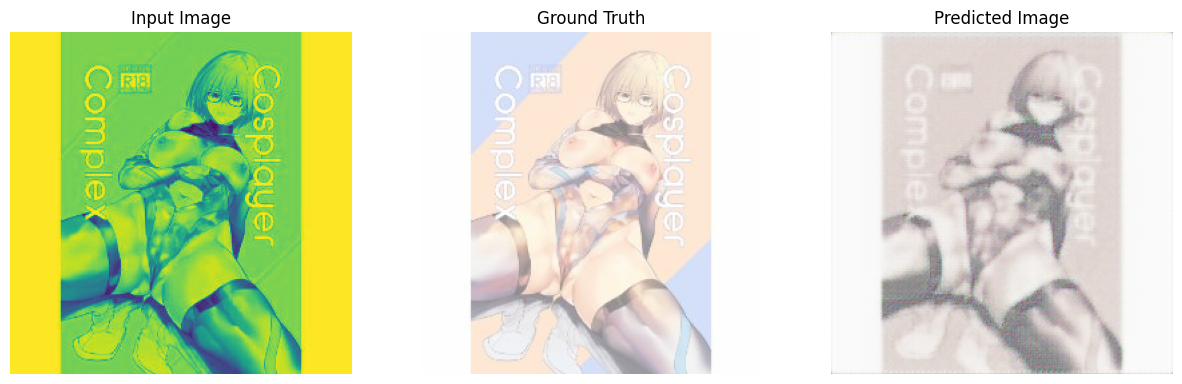

In [ ]:
# for example_input, example_target in test_dataset.take(1):
generate_images(generator, test_input=input_image, tar=real_image)

### Training

In [ ]:
log_dir = "logs/"
summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

In [ ]:
@tf.function(experimental_relax_shapes=True)
# @tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target
        )
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )
    # print("gen_total_loss", gen_total_loss, step=step // 1000)
    # print("gen_gan_loss", gen_gan_loss, step=step // 1000)
    # print("gen_l1_loss", gen_l1_loss, step=step // 1000)
    # print("disc_loss", disc_loss, step=step // 1000)
    with summary_writer.as_default():
        tf.summary.scalar("gen_total_loss", gen_total_loss, step=step // 1000)
        tf.summary.scalar("gen_gan_loss", gen_gan_loss, step=step // 1000)
        tf.summary.scalar("gen_l1_loss", gen_l1_loss, step=step // 1000)
        tf.summary.scalar("disc_loss", disc_loss, step=step // 1000)


In [ ]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in enumerate(train_ds.take(steps)):
        if (step + 1) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f"Time taken for 1000 steps: {time.time()-start:.2f} sec\n")

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        if (step + 1) % 10 == 0:
            print(".", end="", flush=True)

        if (step + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
# def fit(train_ds, test_ds, steps):
#   example_input, example_target = next(iter(test_ds.take(1)))
#   start = time.time()

#   for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
#     if (step) % 1000 == 0:
#       display.clear_output(wait=True)

#       if step != 0:
#         print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

#       start = time.time()

#       generate_images(generator, example_input, example_target)
#       print(f"Step: {step//1000}k")

#     train_step(input_image, target, step)

#     # Training step
#     if (step+1) % 10 == 0:
#       print('.', end='', flush=True)


#     # Save (checkpoint) the model every 5k steps
#     if (step + 1) % 5000 == 0:
#       checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
# import os
# import shutil

# DELETE THE CHECKPOINTS TO RELEASE MEMORHY
# def force_delete_directory_contents(directory):
#     for filename in os.listdir(directory):
#         file_path = os.path.join(directory, filename)
#         try:
#             if os.path.isfile(file_path) or os.path.islink(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 shutil.rmtree(file_path)
#         except Exception as e:
#             print(f"Failed to delete {file_path}. Reason: {e}")

# # Specify the directory you want to clear
# checkpoint_dir = "./training_checkpoints"

# # Call the function to delete the contents of the directory
# force_delete_directory_contents(checkpoint_dir)

In [ ]:
!ls {checkpoint_dir}

ls: cannot access './training_checkpoints': No such file or directory


In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the test set
# for inp, tar in test_dataset.take(5):
# generate_images(generator, inp, tar)
# generate_images(generator, test_input=input_image, tar=real_image)
# for inp, tar in dataset_test.take(5):
#     generate_images(generator, inp, tar)
grayscale_images = tf.data.Dataset.list_files(f"{grayscaled_path}/*.jpg", shuffle=False)
colored_images = tf.data.Dataset.list_files(f"{colored_path}/*.jpg", shuffle=False)

paired_images = tf.data.Dataset.zip((grayscale_images, colored_images))
paired_images = paired_images.map(load)

# BATCH_SIZE = 32
BATCH_SIZE = 16
# Adjust buffer size as needed for shuffling (atleast > than your len(dataset)) in my case I have 5709 colored and grayscale images
BUFFER_SIZE = 550
paired_images = paired_images.shuffle(BUFFER_SIZE)
paired_images = paired_images.batch(BATCH_SIZE)
print(grayscale_images)
print(colored_images)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# fit(train_dataset, test_dataset, steps=40000)
fit(paired_images, paired_images, steps=50)

# Restore the latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

...

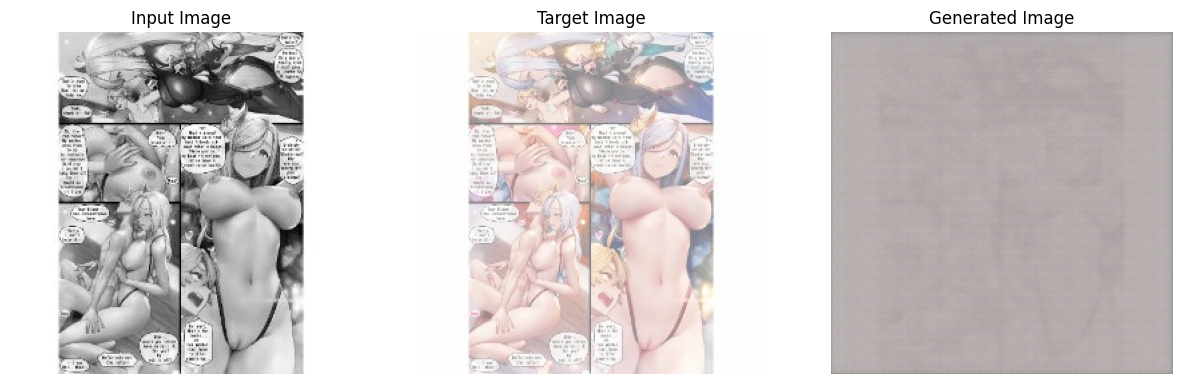

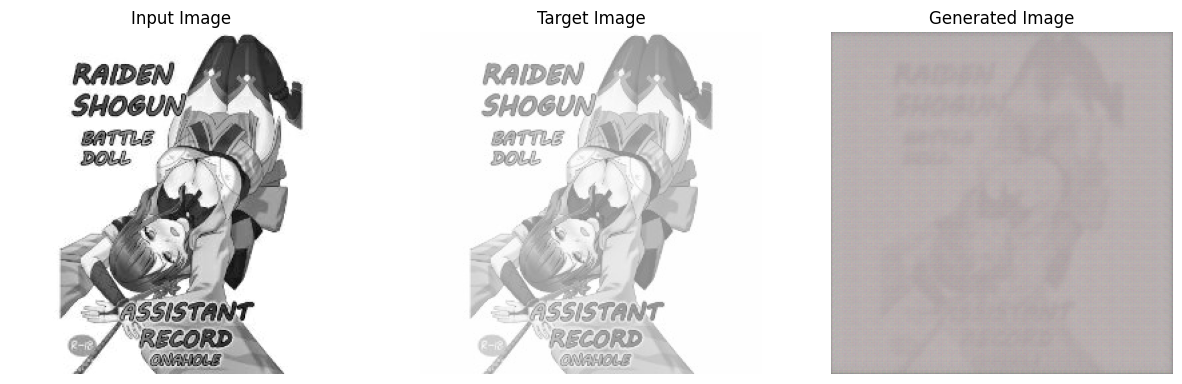

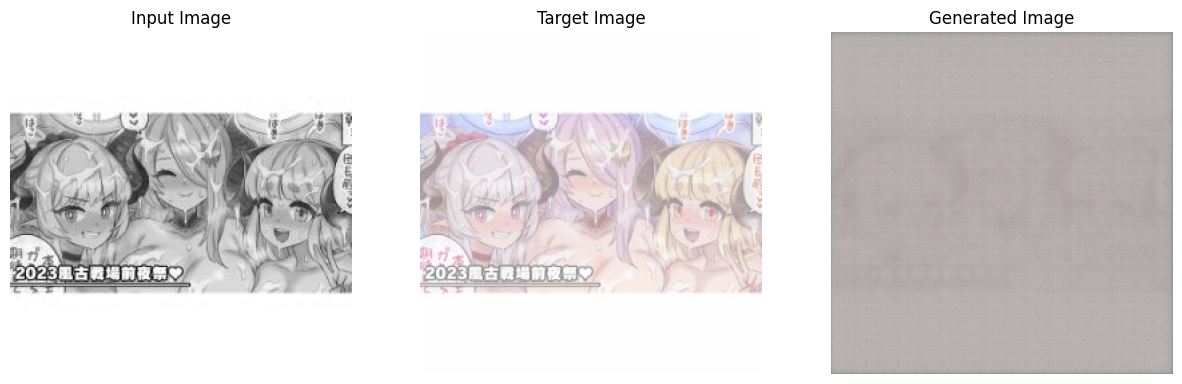

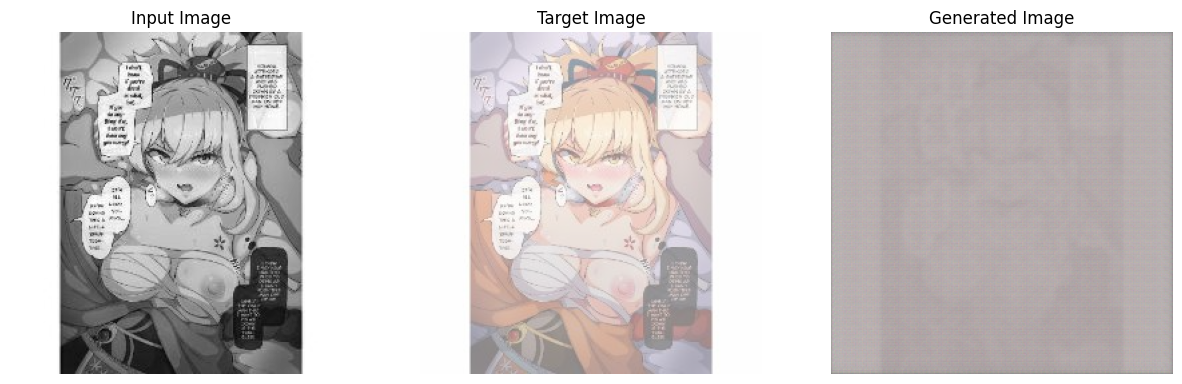

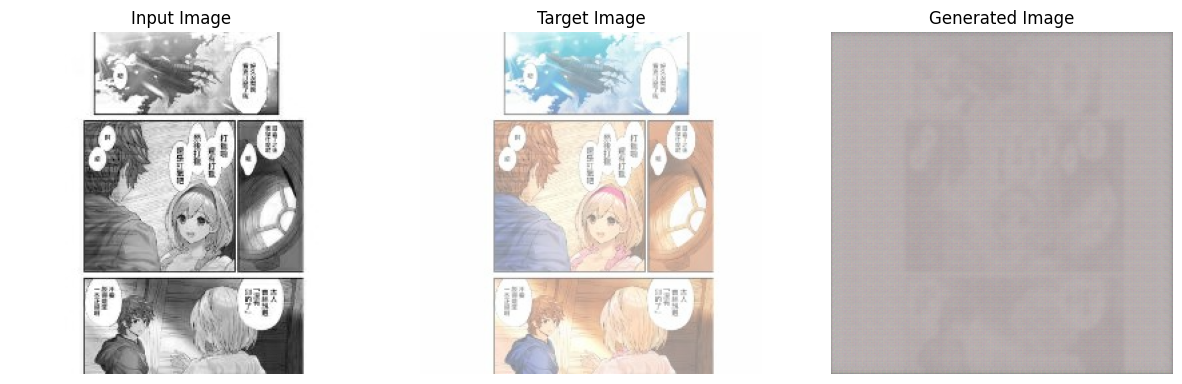

In [ ]:
def generate_and_display_images(model, test_input, tar):
    # Generate images using the generator
    gen_output = model(test_input, training=False)

    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], gen_output[0]]
    title = ["Input Image", "Target Image", "Generated Image"]
    # print(display_list)

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])

        # Ensure pixel values are in the range [0, 1] (Normalizing)
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap="gray")
        plt.axis("off")

    plt.show()

for test_input, target in paired_images.take(5):
    generate_and_display_images(generator, test_input, target)

# Restore the latest checkpoint
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# def generate_and_save_images(model, test_input, tar, epoch):
#     gen_output = model(test_input, training=False)

#     plt.figure(figsize=(15, 15))

#     display_list = [test_input[0], tar[0], gen_output[0]]
#     title = ["Input Image", "Target Image", "Generated Image"]

#     for i in range(3):
#         plt.subplot(1, 3, i + 1)
#         plt.title(title[i])

#         plt.imshow(display_list[i] * 0.5 + 0.5)
#         plt.axis("off")

#     plt.savefig(f"generated_image_at_epoch_{epoch}.png")
#     plt.show()

# # # Example usage inside your training loop
# # for epoch in range(epochs):
# #     for train_input, train_target in train_dataset:
# #         train_step(train_input, train_target)

# #     # Generate and save test images at the end of each epoch
# #     for test_input, test_target in test_dataset:
# #         generate_and_save_images(generator, test_input, test_target, epoch)

# for test_input, target in paired_images.take(5):
#     generate_and_display_images(generator, test_input, target)

# # Restore the latest checkpoint
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
